In [1]:
import itertools
import pathlib
import pyam # version: 1.4.1.dev15+g3563b43

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# these functions can be found in utils.py in this same directory
from utils import (
    make_quantiles,
    make_sequestration_plot_data,
    sequestration_plot,
    share_of_cdr_data,
)

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

# Load Data

In [2]:
data_path = pathlib.Path('../data')

In [3]:
paper_data = pd.concat([
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_data.csv'),
    pd.read_csv(data_path / 'additional_analysis_data.csv'),
])

In [4]:
ar6_data = pd.read_csv(data_path / 'AR6_Scenarios_Database_World_v1.0.csv')
ar6_data = ar6_data[ar6_data.Variable.isin(['Emissions|CO2|AFOLU'])]

In [5]:
df = pyam.IamDataFrame(pd.concat([paper_data, ar6_data]))
df.load_meta(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators for 914 out of 1783 scenarios


In [6]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)

In [7]:
df.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only from 2020',
 'Cumulative AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Cumulat

# Panel 1A

In [8]:
variables = [
    'Emissions|CO2|AFOLU',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU', 
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
]

data = pyam.concat([
    make_quantiles(df, v, cat)
    for v, cat in itertools.product(variables, categories_to_temp.keys())
])

In [9]:
def afolu_line_plot(data, variables, cat, ax=None, years=range(1990, 2051), color='variable'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.25*', '*0.75*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color=color, fill_between=True, ax=ax, alpha=0.1, legend=False) #  cmap='PiYG_r',
    )
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.5*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color=color, ax=ax)  # cmap='PiYG_r',
    )
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[-len(variables):], l[-len(variables):])
    return ax

In [10]:
color_map = {
    'Emissions|CO2|AFOLU': '#' + 'c' * 6,
    'LULUCF Emissions - Reanalyzed': '#33701a',
    'LULUCF Emissions - NGHGI Correction': '#a3176d', 
}
pyam.run_control().update({'color': {'variable': color_map}})

Text(0.5, 0, '')

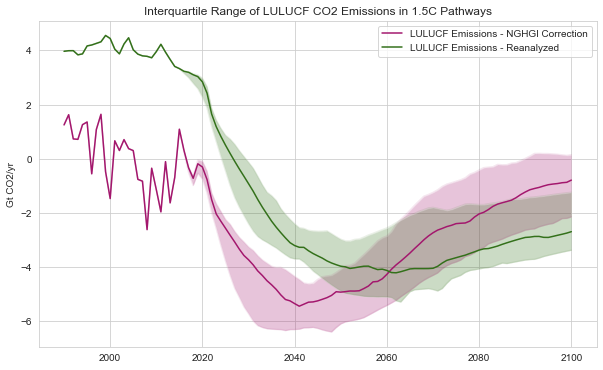

In [11]:
cat = 'C1'

variables = {
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct': 'LULUCF Emissions - Reanalyzed',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU': 'LULUCF Emissions - NGHGI Correction', 
}
fig, ax = plt.subplots(figsize=(10, 6))
afolu_line_plot(data.rename(variable=variables), variables.values(), cat, years=range(1990, 2101), ax=ax)
ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')


## Additional Figures for SI

Text(0.5, 0, '')

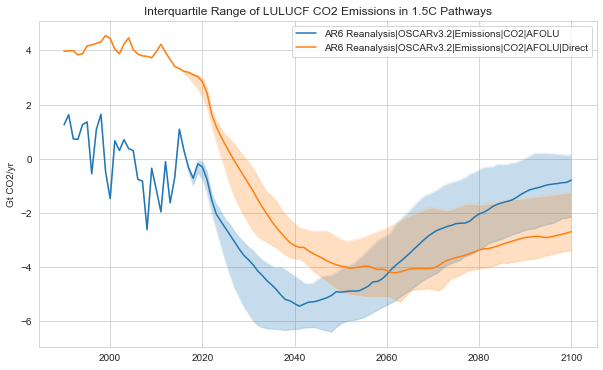

In [12]:
cat = 'C1'
fig, ax = plt.subplots(figsize=(10, 6))
afolu_line_plot(data, variables, cat, years=range(1990, 2101), ax=ax)
ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')

Text(0.5, 0, '')

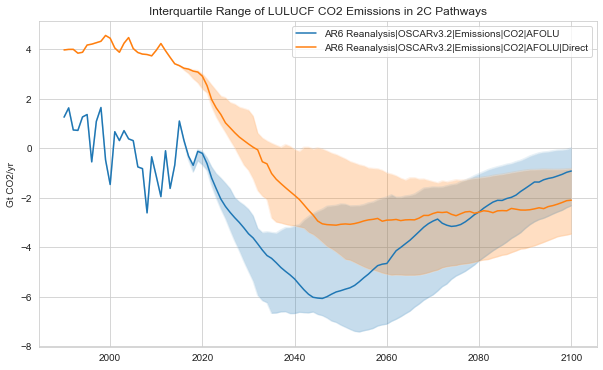

In [13]:
cat = 'C3'
fig, ax = plt.subplots(figsize=(10, 6))
afolu_line_plot(data, variables, cat, years=range(1990, 2101), ax=ax)
ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')

In [14]:
variables

{'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct': 'LULUCF Emissions - Reanalyzed',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU': 'LULUCF Emissions - NGHGI Correction'}

Text(0.5, 0, '')

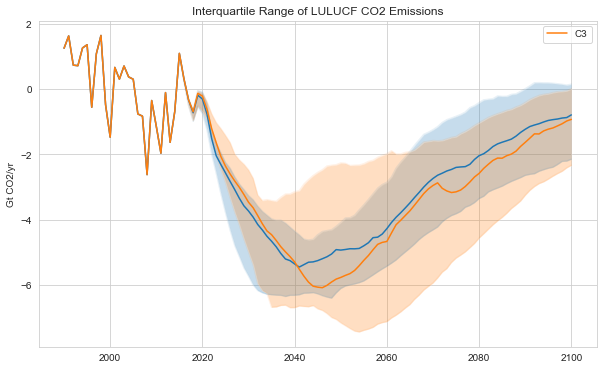

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
afolu_line_plot(
    data, 
    variables=['AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU'], 
    cat=['C1', 'C3'], 
    years=range(1990, 2101), 
    color='model',
    ax=ax
)
ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions')
ax.set_xlabel('')

# Panel 1B

Text(0.5, 0, '')

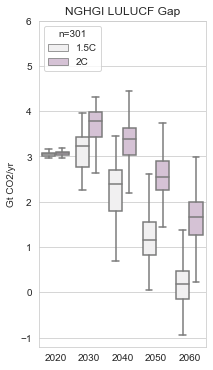

In [16]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU', 
]
name = 'NGHGI LULUCF Gap'
fig, ax = plt.subplots(figsize=(3, 6))
(
    df
    .filter(region='World', variable=variables)
    .filter(Temperature=categories_to_temp.values())
    .filter(year=range(2020, 2061, 10))
    .subtract(variables[0], variables[1], name=name, ignore_units='Mt CO2/yr')
    .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
    .plot
    .box(color='thistle', by='Temperature', ax=ax, showfliers=False)
)
ax.set_title(name)
ax.set_ylim(None, 6)
ax.set_xlabel('')

# Panel 1C

In [17]:
variables = ['Cumulative Carbon Sink - Indirect', 'Cumulative Carbon Sink - Direct']
data, pdata = make_sequestration_plot_data(df.filter(region='World'), variables, categories_to_temp)

Text(0, 0.5, '')

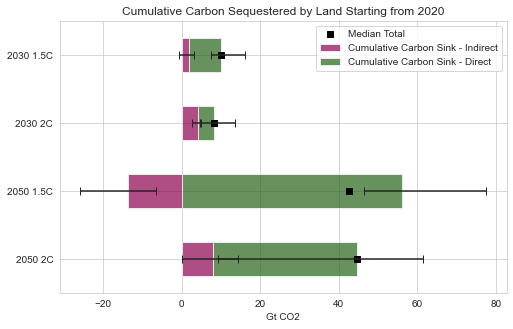

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sequestration_plot(pdata, order=variables, legend={'loc': 'best'}, ax=ax)
ax.set_title('Cumulative Carbon Sequestered by Land Starting from 2020')
ax.set_xlabel('Gt CO2')
ax.set_ylabel('')

## Figures for SI

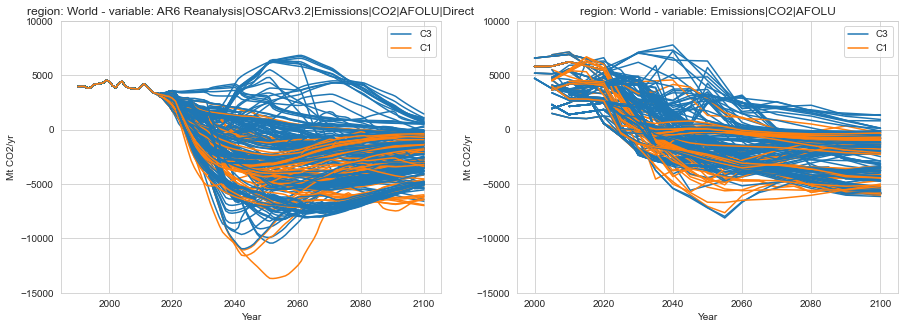

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
variables = ['AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 'Emissions|CO2|AFOLU']
for ax, v in zip(axs, variables):
    (
        df
        .filter(variable=v, region='World')
        .filter(Category=['C1', 'C3'])
        .plot
        .line(color='Category', ax=ax)
    )
    ax.set_ylim(-15e3, 10e3)

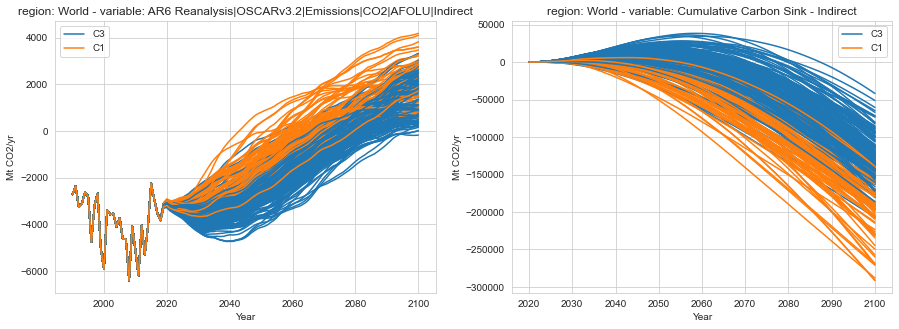

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
variables = ['AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect', 'Cumulative Carbon Sink - Indirect']
for ax, v in zip(axs, variables):
    (
        df
        .filter(variable=v, region='World')
        .filter(Category=['C1', 'C3'])
        .plot
        .line(color='Category', ax=ax)
    )

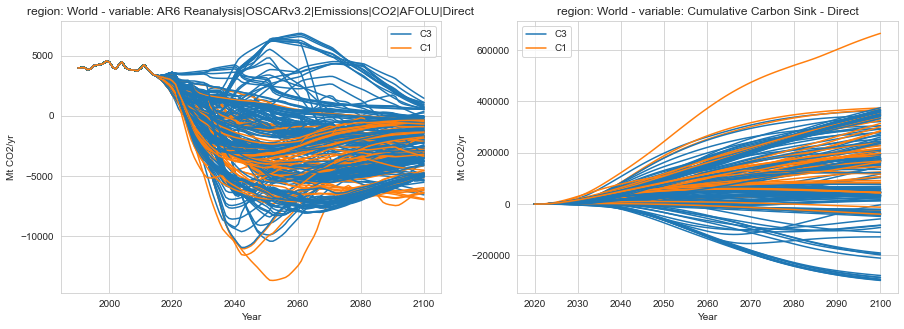

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
variables = ['AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 'Cumulative Carbon Sink - Direct']
for ax, v in zip(axs, variables):
    (
        df
        .filter(variable=v, region='World')
        .filter(Category=['C1', 'C3'])
        .plot
        .line(color='Category', ax=ax)
    )

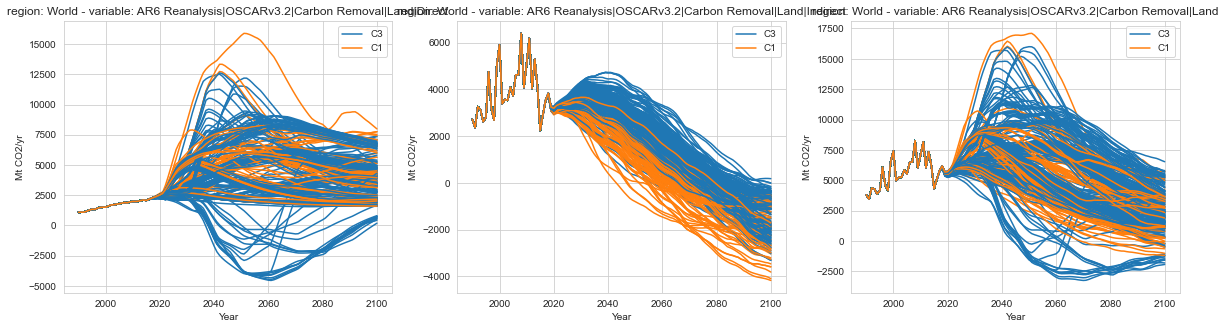

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
variables = [
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct', 
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
]
for ax, v in zip(axs, variables):
    (
        df
        .filter(variable=v, region='World')
        .filter(Category=['C1', 'C3'])
        .plot
        .line(color='Category', ax=ax)
    )

<AxesSubplot:title={'center':'region: World - variable: total land removals offset by 2.7 Gt'}, xlabel='Year', ylabel='Mt CO2/yr'>

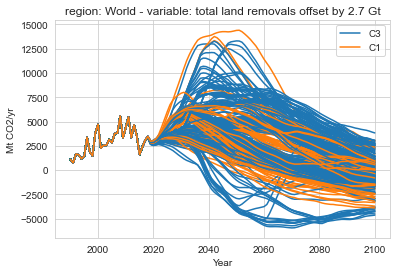

In [23]:
v = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land'
fig, ax = plt.subplots()
(
        df
        .filter(variable=v, region='World')
        .filter(Category=['C1', 'C3'])
        .subtract(v, 2.7e3, name='total land removals offset by 2.7 Gt', ignore_units='Mt CO2/yr')
        .plot
        .line(color='Category', ax=ax)
)

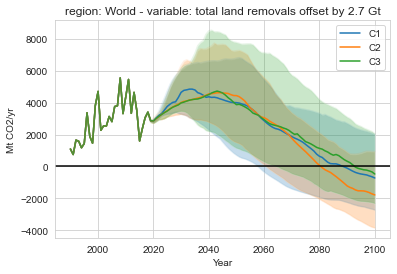

In [24]:
v = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land'
fig, ax = plt.subplots()

data = df.filter(variable=v, region='World').subtract(v, 2.7e3, name='total land removals offset by 2.7 Gt', ignore_units='Mt CO2/yr')
data = pyam.concat([make_quantiles(data, 'total land removals offset by 2.7 Gt', cat) for cat in ['C1', 'C2', 'C3']])

(
        data
        .filter(scenario='*0.5*')
        .plot
        .line(color='model', ax=ax, legend=True)
)
(
        data
        .filter(scenario=['*0.25*', '*0.75*'], keep=False)
        .plot
        .line(color='model', fill_between=True, ax=ax, alpha=0.1)
)
ax.axhline(0, c='k')

In [25]:
df.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases from 2020',
 'Change in AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only from 2020',
 'Cumulative AR6 Reanalysis|OSCARv3.2|Emissions|CO2 from 2020',
 'Cumulat

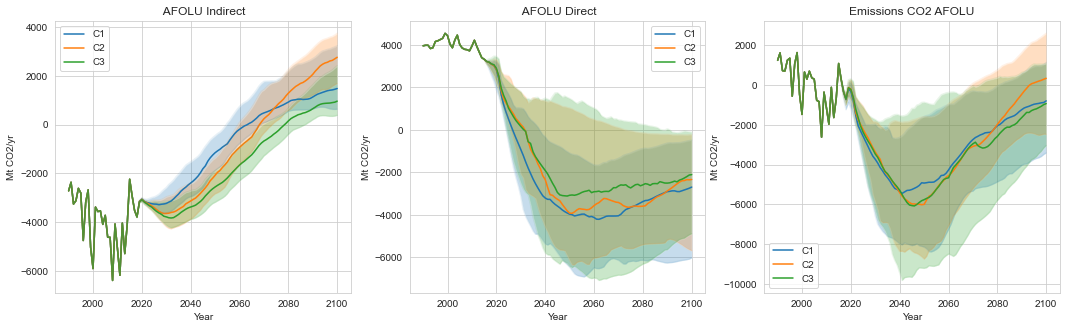

In [26]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
]
fig, axs = plt.subplots(1, len(variables), figsize=(6 * len(variables), 5))

for v, ax in zip(variables, axs):
    data = pyam.concat([make_quantiles(df, v, cat) for cat in ['C1', 'C2', 'C3']])
    (
        data
        .filter(scenario='*0.5*')
        .plot
        .line(color='model', ax=ax, legend=True)
    )
    (
        data
        .filter(scenario=['*0.25*', '*0.75*'], keep=False)
        .plot
        .line(color='model', fill_between=True, ax=ax, alpha=0.1)
    )
    ax.set_title(' '.join(v.split('|')[-3:]).strip('OSCARv3.2'))

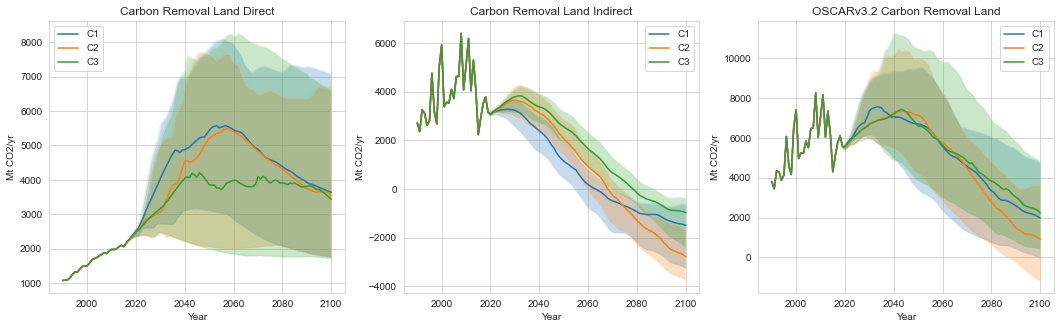

In [27]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct', 
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
]
fig, axs = plt.subplots(1, len(variables), figsize=(6 * len(variables), 5))

for v, ax in zip(variables, axs):
    data = pyam.concat([make_quantiles(df, v, cat) for cat in ['C1', 'C2', 'C3']])
    (
        data
        .filter(scenario='*0.5*')
        .plot
        .line(color='model', ax=ax, legend=True)
    )
    (
        data
        .filter(scenario=['*0.25*', '*0.75*'], keep=False)
        .plot
        .line(color='model', fill_between=True, ax=ax, alpha=0.1)
    )
    ax.set_title(' '.join(v.split('|')[-3:]))

In [28]:
variables = ['AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect', 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct']
hist = [2015, 2020]
future = [2030, 2050, 2070, 2090]
data, pdata = make_sequestration_plot_data(df.filter(variable=variables), variables, categories_to_temp, years=hist + future)
for year in hist:
    pdata = pdata.drop(f'{year} 1.5C').rename(index={f'{year} 2C': str(year)})

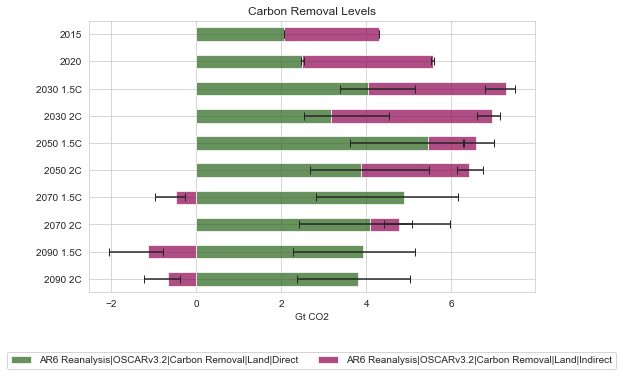

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
sequestration_plot(
    pdata, 
    medians=False, stacked=True, cmap='PiYG_r',
    legend={'loc': 'best'}, ax=ax,
)
ax.set_title('Carbon Removal Levels')
ax.set_xlabel('Gt CO2') 
ax.set_ylabel('')
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['bottom'])

# Panel 1D

In [30]:
variables = {
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal': 'Total CDR', 
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land': 'Land CDR',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land': 'Non-Land CDR',
}
hist = [2015, 2020]
data, pdata = make_sequestration_plot_data(
    df.filter(variable=variables.keys(), region='World').rename({'variable': variables}), 
    variables.values(), 
    categories_to_temp, years=hist + [2030, 2050]
)
for year in hist:
    pdata = pdata.drop(f'{year} 1.5C').rename(index={f'{year} 2C': str(year)})

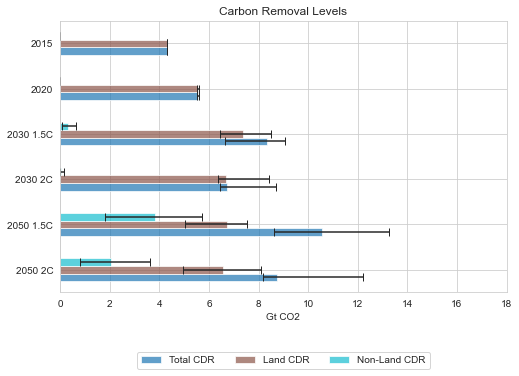

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
sequestration_plot(
    pdata, 
    medians=False, stacked=False, order=variables.values(), cmap='tab10',
    legend={'loc': 'best'}, ax=ax,
)
ax.set_title('Carbon Removal Levels')
ax.set_xlabel('Gt CO2') 
ax.set_ylabel('')
ax.set_xlim(0, 18)
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['bottom'])

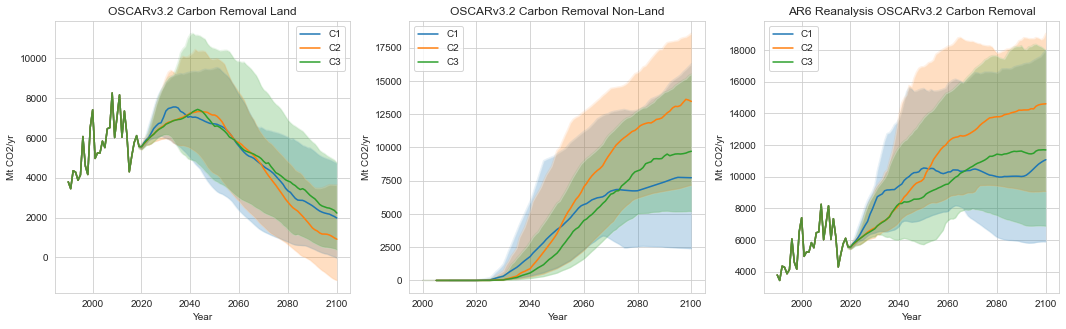

In [32]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land', 
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal',
]
fig, axs = plt.subplots(1, len(variables), figsize=(6 * len(variables), 5))

for v, ax in zip(variables, axs):
    data = pyam.concat([make_quantiles(df, v, cat) for cat in ['C1', 'C2', 'C3']])
    (
        data
        .filter(scenario='*0.5*')
        .plot
        .line(color='model', ax=ax, legend=True)
    )
    (
        data
        .filter(scenario=['*0.25*', '*0.75*'], keep=False)
        .plot
        .line(color='model', fill_between=True, ax=ax, alpha=0.1)
    )
    ax.set_title(' '.join(v.split('|')[-3:]))

# Share of CDR

In [33]:
# fraction of total cdr
total_share = share_of_cdr_data(df, categories_to_temp, quantiles=(0.1, 0.25, 0.5, 0.75, 0.9))
total_share.round(decimals=2)

2020  2030  2040  \
model scenario      region variable                unit                         
1.5C  quantile_0.1  World  Land Share of Total CDR fraction   1.0  0.84  0.50   
      quantile_0.25 World  Land Share of Total CDR fraction   1.0  0.92  0.69   
      quantile_0.5  World  Land Share of Total CDR fraction   1.0  0.96  0.82   
      quantile_0.75 World  Land Share of Total CDR fraction   1.0  0.99  0.93   
      quantile_0.9  World  Land Share of Total CDR fraction   1.0  0.99  0.96   
2C    quantile_0.1  World  Land Share of Total CDR fraction   1.0  0.94  0.65   
      quantile_0.25 World  Land Share of Total CDR fraction   1.0  0.98  0.83   
      quantile_0.5  World  Land Share of Total CDR fraction   1.0  0.99  0.93   
      quantile_0.75 World  Land Share of Total CDR fraction   1.0  1.00  0.97   
      quantile_0.9  World  Land Share of Total CDR fraction   1.0  1.00  0.98   

                                                             2050  2060  2070  \
model scenario      region variable                unit                         
1.5C  quantile_0.1  World  Land Share of Total CDR fraction  0.25  0.17  0.10   
      quantile_0.25 World  Land Share of Total CDR fraction  0.49  0.34  0.25   
      quantile_0.5  World  Land Share of Total CDR fraction  0.65  0.53  0.39   
      quantile_0.75 World  Land Share of Total CDR fraction  0.79  0.66  0.53   
      quantile_0.9  World  Land Share of Total CDR fraction  0.87  0.73  0.65   
2C    quantile_0.1  World  Land Share of Total CDR fraction  0.39  0.24  0.18   
      quantile_0.25 World  Land Share of Total CDR fraction  0.56  0.36  0.27   
      quantile_0.5  World  Land Share of Total CDR fraction  0.77  0.60  0.44   
      quantile_0.75 World  Land Share of Total CDR fraction  0.90  0.76  0.59   
      quantile_0.9  World  Land Share of Total CDR fraction  0.94  0.83  0.65   

                                                             2080  2090  2100  
model scenario      region variable                unit                        
1.5C  quantile_0.1  World  Land Share of Total CDR fraction  0.06  0.04 -0.00  
      quantile_0.25 World  Land Share of Total CDR fraction  0.19  0.11  0.06  
      quantile_0.5  World  Land Share of Total CDR fraction  0.31  0.24  0.19  
      quantile_0.75 World  Land Share of Total CDR fraction  0.44  0.38  0.36  
      quantile_0.9  World  Land Share of Total CDR fraction  0.64  0.63  0.66  
2C    quantile_0.1  World  Land Share of Total CDR fraction  0.10  0.06  0.03  
      quantile_0.25 World  Land Share of Total CDR fraction  0.21  0.18  0.14  
      quantile_0.5  World  Land Share of Total CDR fraction  0.33  0.26  0.20  
      quantile_0.75 World  Land Share of Total CDR fraction  0.45  0.35  0.29  
      quantile_0.9  World  Land Share of Total CDR fraction  0.51  0.44  0.40

<AxesSubplot:title={'center':'region: World - variable: Land Share of Total CDR'}, xlabel='Year', ylabel='fraction'>

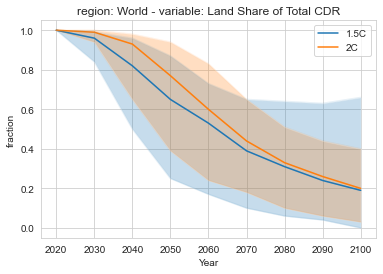

In [34]:
fig, ax = plt.subplots()
data = pyam.IamDataFrame(total_share.round(decimals=2))
(
        data
        .filter(scenario='*0.5*')
        .plot
        .line(color='model', ax=ax, legend=True)
)
(
        data
        .filter(scenario=['*0.25*', '*0.75*'], keep=False)
        .plot
        .line(color='model', fill_between=True, ax=ax, alpha=0.1)
)

In [35]:
# fraction of *new* cdr
# negative values arise because land begins to store less carbon than it did in 2020
# accordingly, this metric only really makes sense until ~2050
new_share = share_of_cdr_data(df, categories_to_temp, offset=2020)
new_share.round(decimals=2)

2030  2040  2050  \
model scenario      region variable                unit                         
1.5C  quantile_0.25 World  Land Share of Total CDR fraction  0.74  0.30 -0.09   
      quantile_0.5  World  Land Share of Total CDR fraction  0.89  0.58  0.27   
      quantile_0.75 World  Land Share of Total CDR fraction  0.94  0.73  0.51   
2C    quantile_0.25 World  Land Share of Total CDR fraction  0.92  0.49  0.07   
      quantile_0.5  World  Land Share of Total CDR fraction  0.98  0.84  0.63   
      quantile_0.75 World  Land Share of Total CDR fraction  1.00  0.92  0.79   

                                                             2060  2070  2080  \
model scenario      region variable                unit                         
1.5C  quantile_0.25 World  Land Share of Total CDR fraction -0.39 -0.53 -0.61   
      quantile_0.5  World  Land Share of Total CDR fraction  0.05 -0.19 -0.40   
      quantile_0.75 World  Land Share of Total CDR fraction  0.23  0.02 -0.12   
2C    quantile_0.25 World  Land Share of Total CDR fraction -0.26 -0.53 -0.60   
      quantile_0.5  World  Land Share of Total CDR fraction  0.34  0.03 -0.19   
      quantile_0.75 World  Land Share of Total CDR fraction  0.52  0.22  0.01   

                                                             2090  2100  
model scenario      region variable                unit                  
1.5C  quantile_0.25 World  Land Share of Total CDR fraction -0.74 -0.79  
      quantile_0.5  World  Land Share of Total CDR fraction -0.49 -0.53  
      quantile_0.75 World  Land Share of Total CDR fraction -0.12 -0.17  
2C    quantile_0.25 World  Land Share of Total CDR fraction -0.71 -0.77  
      quantile_0.5  World  Land Share of Total CDR fraction -0.36 -0.55  
      quantile_0.75 World  Land Share of Total CDR fraction -0.18 -0.26